# Tutorial

In [1]:
# import modules: `pip install defigraph`
from defigraph.Graph import Graph
from defigraph.Edge import Edge
from defigraph.Vertex import Vertex
from defigraph.Pool import Pool

In [2]:
# Option 1: Use data from cached results
import json

with open('data.json') as f:
  data = json.load(f)

In [3]:
# Option 2: Use data from API Call
import os
import json
import requests
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("api_key")
base_url = "https://gateway.thegraph.com/api"
# ETH-mainnet 
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV" # Uniswap V3
subgraph_url = f"{base_url}/subgraphs/id/{subgraph_id}"
headers = {
  'Content-Type': 'application/json',
  'Authorization': f'Bearer {api_key}'
}
payload = {"query": "{ pools (orderBy: volumeUSD, orderDirection: desc, first: 15) { token0 { name symbol decimals id } token0Price token1Price token1 { decimals name symbol id } feeTier id } }"} # V3
response = requests.post(subgraph_url, headers=headers, json=payload)

# Check if the request was successful
if response.status_code == 200:
  data = response.json()['data']['pools']
else:
  print("Error:", response.text)

In [4]:
from web3 import Web3
edges = []

for pool in data:
  fee = pool['feeTier']  

  token0 = pool['token0']['symbol']
  token0_decimals = int(pool['token0']['decimals'])
  token0_address = Web3.to_checksum_address(pool['token0']['id'])
  token0Price = float(pool['token0Price'])

  token1 = pool['token1']['symbol']
  token1_decimals = int(pool['token1']['decimals'])
  token1_address = Web3.to_checksum_address(pool['token1']['id'])
  token1Price = float(pool['token1Price'])

  pool_address = Web3.to_checksum_address(pool['id'])

  u = Vertex(token0, token0_decimals, token0_address)
  v = Vertex(token1, token1_decimals, token1_address)

  pool = Pool(pool_address=pool_address, token0=u, token1=v, fee=fee, token0_price=token0Price, token1_price=token1Price)
  pool2 = Pool(pool_address=pool_address, token0=v, token1=u, fee=fee, token0_price=token1Price, token1_price=token0Price)
  edge = Edge(pool=pool)
  edge2 = Edge(pool=pool2)
  edges.append(edge)
  edges.append(edge2)

g = Graph(edges=edges)
g 

{USDC: [([USDC, WETH, (-7.881909788066618, (USDC, WETH, '500'))]), ([USDC, USDT, (2.603404148073326e-05, (USDC, USDT, '100'))]), ([USDC, WETH, (-7.880402355841212, (USDC, WETH, '3000'))]), ([USDC, DAI, (-2.7236057215862437e-05, (USDC, DAI, '100'))]), ([USDC, USDT, (0.0004042244892704167, (USDC, USDT, '500'))]), ([USDC, WBTC, (-11.128371726172517, (USDC, WBTC, '3000'))]), ([USDC, WETH, (-7.8822837447123915, (USDC, WETH, '100'))])], WETH: [([WETH, USDC, (7.881909788066618, (WETH, USDC, '500'))]), ([WETH, USDT, (7.882140336438116, (WETH, USDT, '500'))]), ([WETH, USDC, (7.880402355841212, (WETH, USDC, '3000'))]), ([WETH, WBTC, (-3.2491176940577815, (WETH, WBTC, '500'))]), ([WETH, USDT, (7.880577082799053, (WETH, USDT, '3000'))]), ([WETH, DAI, (7.88172863733255, (WETH, DAI, '500'))]), ([WETH, USDT, (7.882176002159107, (WETH, USDT, '100'))]), ([WETH, WBTC, (-3.2496937870038214, (WETH, WBTC, '3000'))]), ([WETH, wstETH, (-0.1672074578063098, (WETH, wstETH, '100'))]), ([WETH, DAI, (7.8804165902

In [5]:
# for i in g.get_vertices:
#   print(i)

e = []
for key, edge in g.adjascency_list.items():
  e.extend(edge)

print(len(e)) 
print(len(edges))
print(len(g.get_edges()))

30
30
30


In [6]:

def bellman_ford(graph: Graph, start_vertex: Vertex):
  distances = {key: float('inf') for key in graph.vertices}
  predecessor = {key: None for key in graph.vertices}

  distances[start_vertex] = 0

  for i in range(len(graph.vertices) - 1):
    for edge in g.get_edges():
      (u,v,w) = edge
      if distances[v] > round(distances[u] + w[0], 2):
        distances[v] = distances[u] + w[0]
        predecessor[v] = (u, w) 

  for edge in g.get_edges():
    (u,v,w) = edge
    cycle = [v]
    if distances[v] > distances[u] + w[0]:
      curr = [u]
      # distances[v] = distances[u] + w[0]
      # predecessor[v] = (u, w) 
      # while []
      print("🌟 CYCLE FOUND")


  return distances, predecessor
bellman_ford(g, Vertex("WETH", 18, Web3.to_checksum_address("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2")))

🌟 CYCLE FOUND
🌟 CYCLE FOUND
🌟 CYCLE FOUND
🌟 CYCLE FOUND
🌟 CYCLE FOUND
🌟 CYCLE FOUND
🌟 CYCLE FOUND
🌟 CYCLE FOUND
🌟 CYCLE FOUND
🌟 CYCLE FOUND
🌟 CYCLE FOUND


({USDC: 7.878677939168696,
  WETH: 0,
  USDT: 7.878703973210177,
  WBTC: -3.2496937870038214,
  DAI: 7.8786507031114805,
  wstETH: -0.1672074578063098},
 {USDC: (WBTC, (11.128371726172517, (WBTC, USDC, '3000'))),
  WETH: None,
  USDT: (USDC, (2.603404148073326e-05, (USDC, USDT, '100'))),
  WBTC: (WETH, (-3.2496937870038214, (WETH, WBTC, '3000'))),
  DAI: (USDC, (-2.7236057215862437e-05, (USDC, DAI, '100'))),
  wstETH: (WETH, (-0.1672074578063098, (WETH, wstETH, '100')))})

[([USDC, WETH, (-7.881909788066618, (USDC, WETH, '500'))]), ([WETH, USDC, (7.881909788066618, (WETH, USDC, '500'))]), ([WETH, USDT, (7.882140336438116, (WETH, USDT, '500'))]), ([USDT, WETH, (-7.882140336438116, (USDT, WETH, '500'))]), ([USDC, USDT, (2.603404148073326e-05, (USDC, USDT, '100'))]), ([USDT, USDC, (-2.6034041480700942e-05, (USDT, USDC, '100'))]), ([USDC, WETH, (-7.880402355841212, (USDC, WETH, '3000'))]), ([WETH, USDC, (7.880402355841212, (WETH, USDC, '3000'))]), ([WBTC, WETH, (3.2491176940577815, (WBTC, WETH, '500'))]), ([WETH, WBTC, (-3.2491176940577815, (WETH, WBTC, '500'))]), ([WETH, USDT, (7.880577082799053, (WETH, USDT, '3000'))]), ([USDT, WETH, (-7.880577082799053, (USDT, WETH, '3000'))]), ([DAI, WETH, (-7.88172863733255, (DAI, WETH, '500'))]), ([WETH, DAI, (7.88172863733255, (WETH, DAI, '500'))]), ([WETH, USDT, (7.882176002159107, (WETH, USDT, '100'))]), ([USDT, WETH, (-7.882176002159107, (USDT, WETH, '100'))]), ([WBTC, WETH, (3.2496937870038214, (WBTC, WETH, '3000'

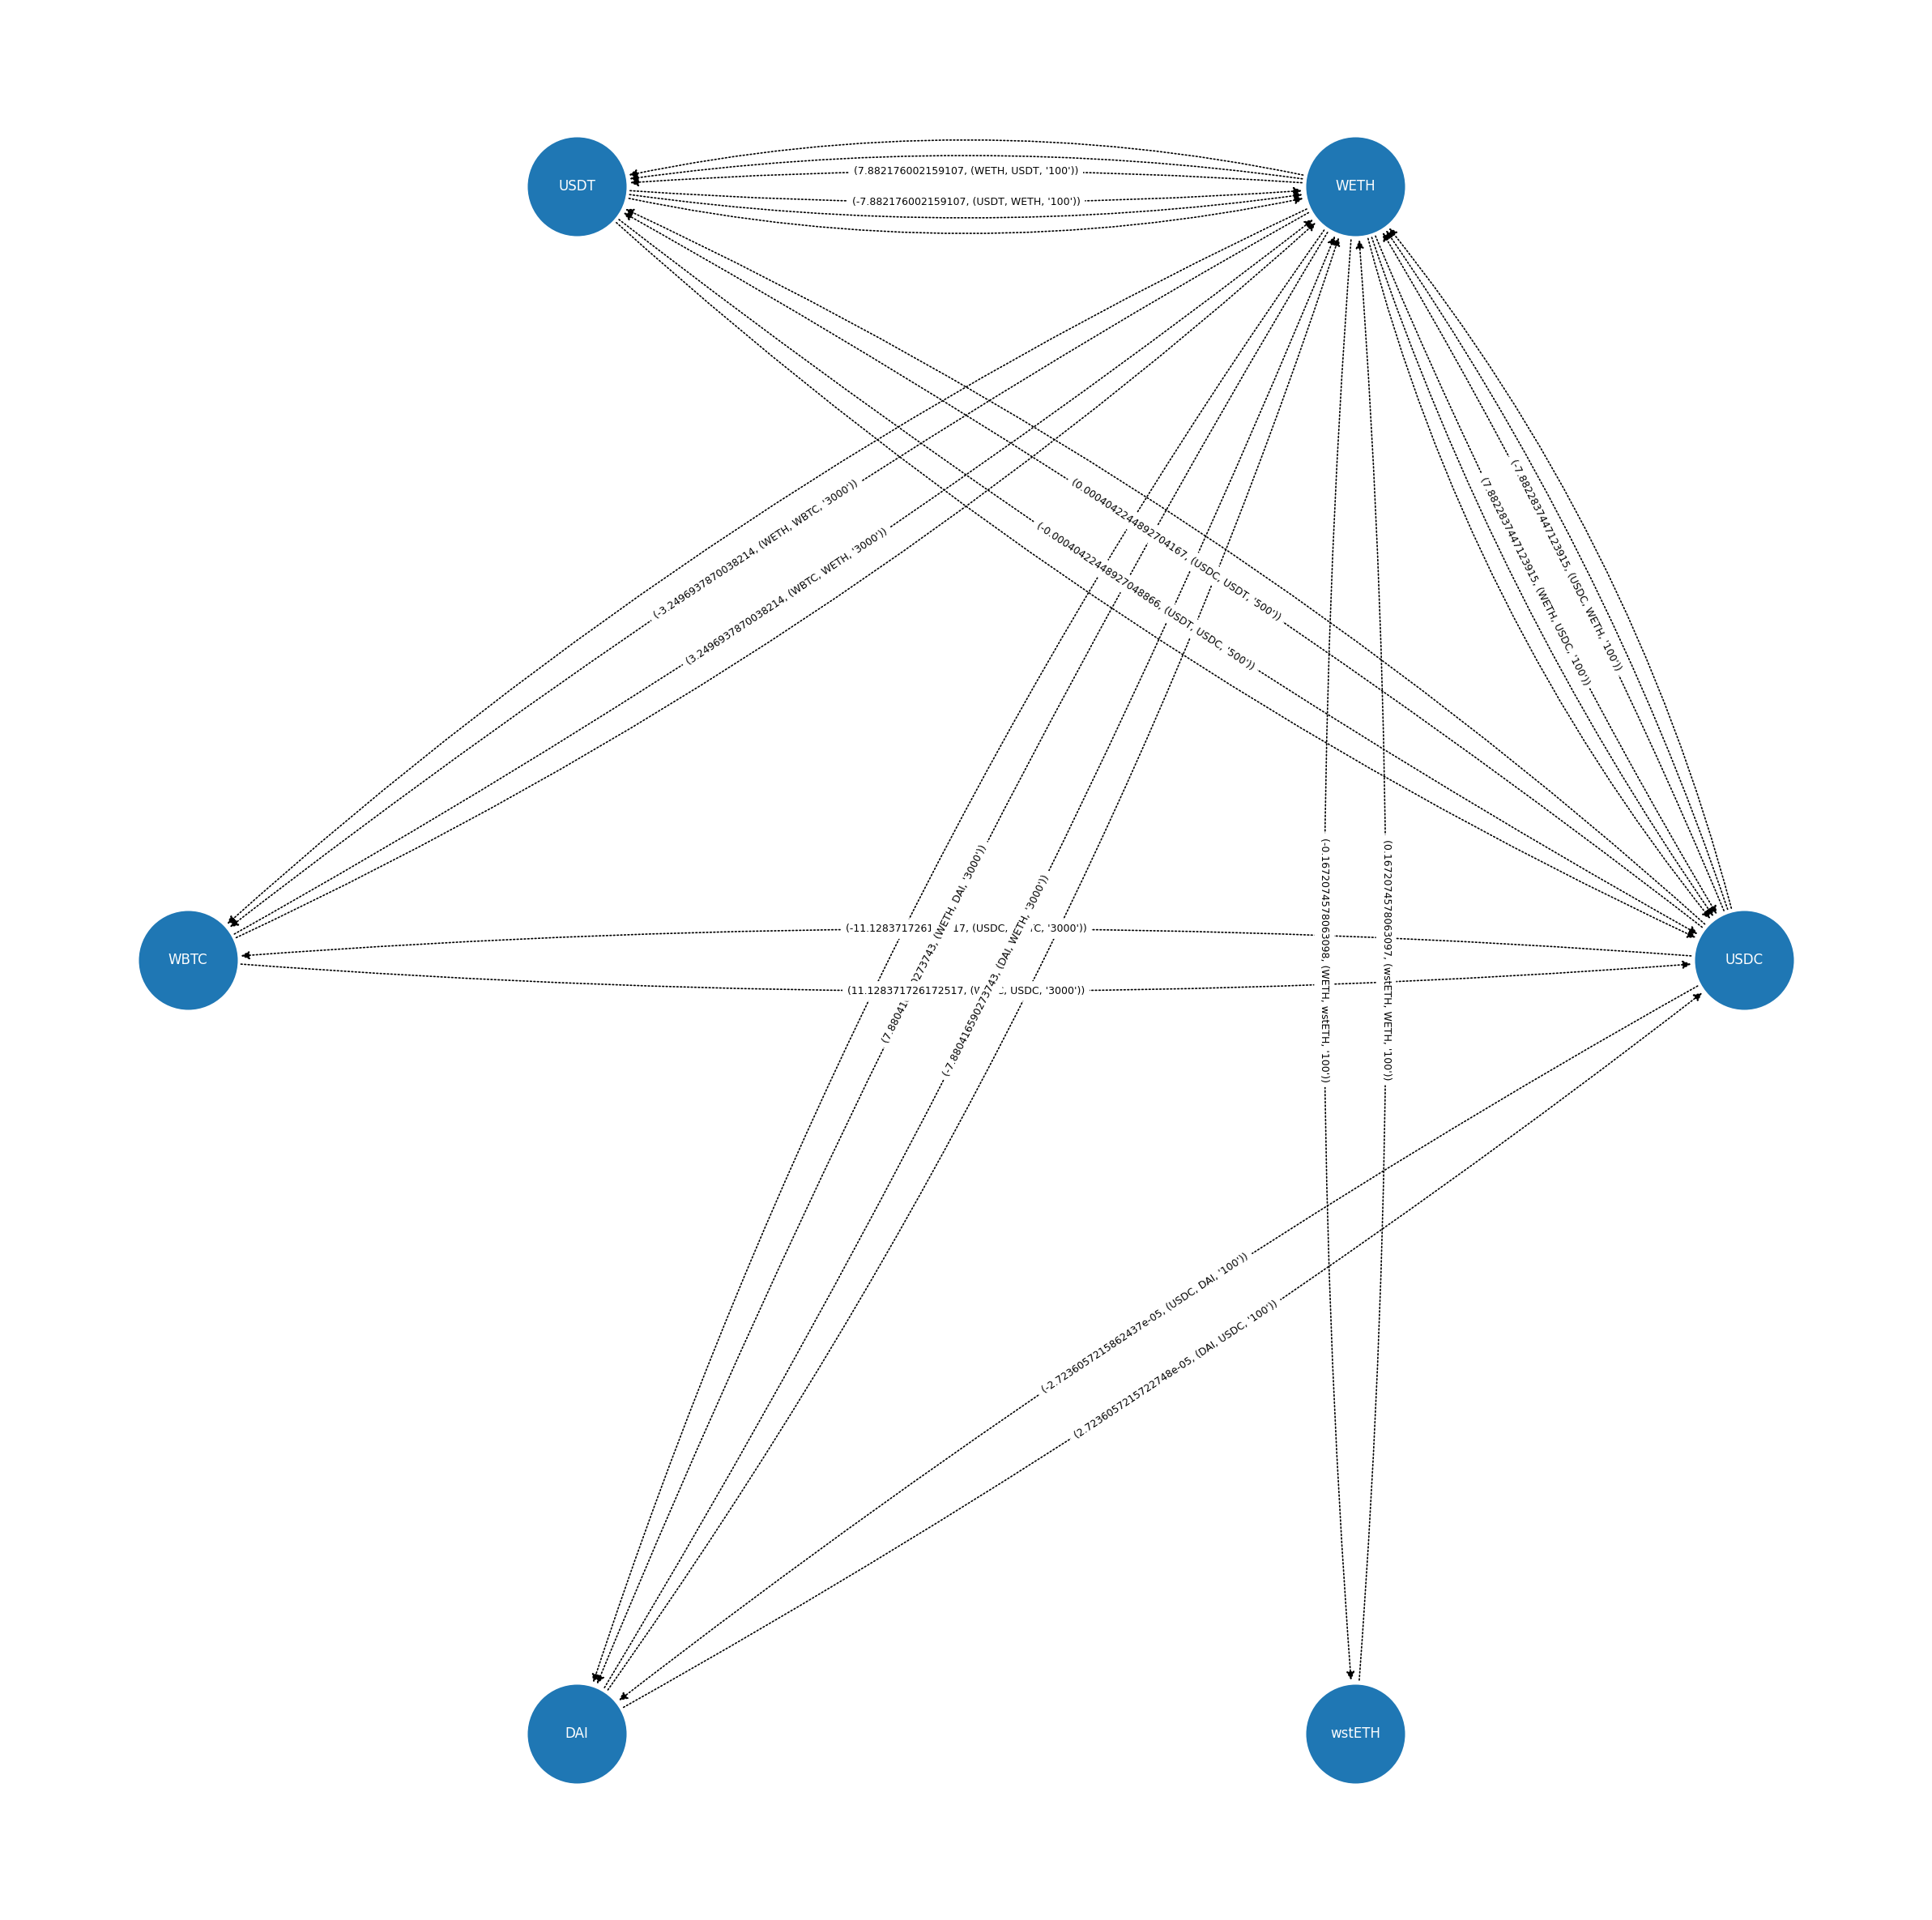

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it

G = nx.MultiDiGraph()
print(edges)
print(g.vertices)
G.add_weighted_edges_from(edges)
plt.figure(3, figsize=(10, 10), dpi=300)

pos = nx.circular_layout(G)

# all_cycles = []

# l = [i for i in edges[1]]
# print(edges[1])
# u = Vertex("USDC", 6, "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48")
# v = Vertex("WETH", 18, "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2")

# nx.draw_networkx_edges(nx.DiGraph(), pos, edge_color="red", width=2, connectionstyle="arc3,rad=0.02", edgelist=g["WETH"])

nx.draw_networkx_nodes(G, pos, node_color="tab:blue", node_size=800)
connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.04] * 4)]
nx.draw_networkx_edges(G, pos, edge_color="black", width=.4, connectionstyle=connectionstyle, min_source_margin=5, min_target_margin=5, style='dotted', arrowsize=5, node_size=1000)
nx.draw_networkx_labels(G, pos, font_size=4, font_family="sans-serif", font_color="white")
nx.draw_networkx_edge_labels(G,pos, font_size=3, connectionstyle=connectionstyle, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})

plt.axis("off")
plt.show()

In [69]:
weth = g[Vertex("WETH", 18, Web3.to_checksum_address("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"))][0][0]
usdc = g[Vertex("WETH", 18, Web3.to_checksum_address("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"))][0][1]

In [70]:
g[weth]

[([WETH, USDC, (7.879321812006355, (WETH, USDC, '500'))]),
 ([WETH, USDT, (7.879715050389392, (WETH, USDT, '500'))]),
 ([WETH, USDC, (7.880402355841212, (WETH, USDC, '3000'))]),
 ([WETH, WBTC, (-3.2496322560781117, (WETH, WBTC, '500'))]),
 ([WETH, USDT, (7.880574344888483, (WETH, USDT, '3000'))]),
 ([WETH, DAI, (7.880057714155948, (WETH, DAI, '500'))]),
 ([WETH, USDT, (7.8793462686716635, (WETH, USDT, '100'))]),
 ([WETH, WBTC, (-3.2496937870038214, (WETH, WBTC, '3000'))]),
 ([WETH, wstETH, (-0.16720783739369716, (WETH, wstETH, '100'))]),
 ([WETH, DAI, (7.880416590273743, (WETH, DAI, '3000'))]),
 ([WETH, USDC, (7.879217223838644, (WETH, USDC, '100'))])]

In [71]:
g[usdc]

[([USDC, WETH, (-7.879321812006355, (USDC, WETH, '500'))]),
 ([USDC, USDT, (2.1768038957484844e-05, (USDC, USDT, '100'))]),
 ([USDC, WETH, (-7.880402355841212, (USDC, WETH, '3000'))]),
 ([USDC, DAI, (-2.7244621587810092e-05, (USDC, DAI, '100'))]),
 ([USDC, USDT, (0.0004042244892704167, (USDC, USDT, '500'))]),
 ([USDC, WBTC, (-11.128371726172517, (USDC, WBTC, '3000'))]),
 ([USDC, WETH, (-7.879217223838643, (USDC, WETH, '100'))])]